# Codes for reproducing the cluster expansion model of v
1. The below codes are for processing the structural data of the DRX Li-V-Nb-O-F compounds.
2. All structural data used in these codes are directly from SCAN+rVV10 relaxed DFT structures (using VASP). 
3. All volumes, lattice parameters, metal coordinations in the csv file were obtained from tools provided in the pymatgen package (https://pymatgen.org/).

# Libraries and packages used

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.linear_model import LassoCV, Lasso, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning
import itertools
%matplotlib inline

# Read the raw data files as pandas dataframe

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('LVNOF_rawdata.csv')
df.drop(columns=['Unnamed: 0', 'Normalized Energy (eV/atom)', 'Functional']);

# Calculate the partial molar extraction volume of Li

In [3]:
all_dv = [];
tet_li_frac = []; oct_li_frac = []; tet_v_frac = []; oct_v_frac = []; nb_frac = []; v_frac = [];

for idx, config in enumerate(df["Config"]):
    li_cont = df.iloc[idx]["Pristine Li Frac"]; f_cont = df.iloc[idx]["F Frac"];
    de_v = (df.iloc[idx]["Volume (A^3)"]) # Volume of the delithiated structure
    pr_v = (df[(df["Config"] == config) & (df["Pristine Li Frac"] == li_cont) & 
               (df["F Frac"] == f_cont) & (df["State"] == 'Pristine')]["Volume (A^3)"].values[0]) # Volume of the lithiated structure
    de_li_frac = df.iloc[idx]["True Li"] # Number of Li in the delithiated structure
    pr_li_frac = df[(df["Config"] == config) & (df["Pristine Li Frac"] == li_cont) & 
                    (df["F Frac"] == f_cont) & (df["State"] == 'Pristine')]["True Li"].values[0] # Number of Li in the lithiated structure
    x_li_change = (pr_li_frac - de_li_frac) # Change of number of Li upon delithiation
    if x_li_change == 0:
        all_dv.append(0) # If lithiated structure is selected, put 0 volume change
    else:
        dV = (de_v - pr_v) / x_li_change; all_dv.append(dV); # Else, calculate partial molar extraction volume of Li
    # Also include all the concentration of site-distinguished species, normalized by the number of anions in the structure
    x_tet_li = df.iloc[idx]["Tet Li"] / (df.iloc[idx]["True F"] + df.iloc[idx]["True O"])
    tet_li_frac.append(x_tet_li)
    x_oct_li = df.iloc[idx]["Oct Li"] / (df.iloc[idx]["True F"] + df.iloc[idx]["True O"])
    oct_li_frac.append(x_oct_li)
    x_tet_v = df.iloc[idx]["Tet V"] / (df.iloc[idx]["True F"] + df.iloc[idx]["True O"])
    tet_v_frac.append(x_tet_v)
    x_oct_v = df.iloc[idx]["Oct V"] / (df.iloc[idx]["True F"] + df.iloc[idx]["True O"])
    oct_v_frac.append(x_oct_v)
    x_nb = df.iloc[idx]["True Nb"] / (df.iloc[idx]["True F"] + df.iloc[idx]["True O"])
    nb_frac.append(x_nb)
    v = np.round(1 - li_cont/2 - x_nb, 3); v_frac.append(v)

df_all = df; df_all["dV/dx"] = all_dv; df_all["x-tet-Li"] = tet_li_frac; df_all["x-oct-Li"] = oct_li_frac; df_all["x-tet-V"] = tet_v_frac;
df_all["x-oct-V"] = oct_v_frac; df_all["x-Nb"] = nb_frac; df_all["x-V"] = v_frac;
df_all.drop(columns = ['Unnamed: 0', 'Functional', 'Normalized Energy (eV/atom)']);

# Collect all partial molar extraction volume of Li in the scenario of delithiation by maximum V-redox capacity

In [4]:
ECap = df_all; index_tobe_dropped = [];

for idx, state in enumerate(df_all["State"]):
    li_cont = df_all.iloc[idx]["Pristine Li Frac"]; f_cont = df_all.iloc[idx]["F Frac"];
    if state == 'Pristine':
        index_tobe_dropped.append(idx) # Throw away lithiated structures
    elif state == 'FullDeLiECap':
        pass # Keeping this case
    elif ((state == 'FullDeLi') and np.isnan(df[(df["Pristine Li Frac"] == li_cont) & (df["F Frac"] == f_cont) & 
                                               (df["State"] == "FullDeLiECap")]["Volume (A^3)"].mean()) == True):
        pass # Keeping the case where complete delithiation is equivalent to the delithiation by V-redox capacity
    else:
        index_tobe_dropped.append(idx)

ECap = ECap.drop(ECap.index[index_tobe_dropped]); 
ECap.drop(columns = ['Unnamed: 0', 'Functional', 'Normalized Energy (eV/atom)']);

# Collect all partial molar extraction volume of Li in the scenario of delithiation by 0.2 Li/anion

In [5]:
DeLi4 = df_all; index_tobe_dropped = []

for idx, state in enumerate(df_all["State"]):
    li_cont = df_all.iloc[idx]["Pristine Li Frac"]; f_cont = df_all.iloc[idx]["F Frac"];
    if state == 'Pristine':
        index_tobe_dropped.append(idx) # Throw away lithiated structures
    elif state == 'DeLi4Li':
        pass # Keeping this case
    elif ((state == 'FullDeLiECap') and np.isnan(df_all[(df_all["Pristine Li Frac"] == li_cont) & (df_all["F Frac"] == f_cont) & 
                                                        (df_all["State"] == "DeLi4Li")]["Volume (A^3)"].mean()) == True):
        pass # Keeping the case where 0.2 Li/anion delithiation is equivalent to the delithiation by V-redox capacity
    else:
        index_tobe_dropped.append(idx)

DeLi4 = DeLi4.drop(DeLi4.index[index_tobe_dropped]); 
DeLi4.drop(columns = ['Unnamed: 0', 'Functional', 'Normalized Energy (eV/atom)']);

# Linear regression of all partial molar extraction volume of Li in the scenario of delithiation by maximum V-redox capacity

In [6]:
x_li_tet = ECap["x-tet-Li"].values 
x_v_tet = ECap["x-tet-V"].values
x_nb = ECap["x-Nb"].values
x_f = (ECap["F Frac"].values)/2
vol_matrix = np.ravel([ECap["dV/dx"].values]);
corr_matrix = np.transpose([x_li_tet, x_v_tet, x_nb, x_f]);

lasso_regression = LassoCV(n_alphas=10000, fit_intercept=True, tol = 1e-10) # 5-fold CV is used
regression = lasso_regression.fit(corr_matrix, vol_matrix);
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
best_alpha = regression.alpha_; # Picking out the best L1-penalty candidate

vol_coeff = regression.coef_ # Fitted coefficients of partial molar extraction volume of Li

print("The volume coefficient for tet-Li, tet-V, Nb and F are given by\n")
print(vol_coeff)

# Calculate the r2-score and RMSE between the testing and the predict volume
r2score = regression.score(corr_matrix, vol_matrix) 
vol_predict = regression.predict(corr_matrix)
rmse = mean_squared_error(vol_matrix, vol_predict, squared = False)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
print("\nThe r2score is: " + str(r2score))
print("\nThe RMSE is: " + str(rmse))
print("\nThe intercept is: " + str(regression.intercept_))

The volume coefficient for tet-Li, tet-V, Nb and F are given by

[14.40800495 18.76247022 16.3472117   2.33774687]

The r2score is: 0.7292939043233213

The RMSE is: 1.3387498680836867

The intercept is: -3.043956629771408


# Linear regression of all partial molar extraction volume of Li in the scenario of delithiation by 0.2 Li/anion

In [7]:
x_li_tet = DeLi4["x-tet-Li"].values 
x_v_tet = DeLi4["x-tet-V"].values
x_nb = DeLi4["x-Nb"].values
x_f = (DeLi4["F Frac"].values)/2
vol_matrix = np.ravel([DeLi4["dV/dx"].values]);
corr_matrix = np.transpose([x_li_tet, x_v_tet, x_nb, x_f]);

lasso_regression = LassoCV(n_alphas=10000, fit_intercept=True, tol = 1e-10) # 5-fold CV is used
regression = lasso_regression.fit(corr_matrix, vol_matrix);
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
best_alpha = regression.alpha_; # Picking out the best L1-penalty candidate

vol_coeff = regression.coef_; # Fitted coefficients of partial molar extraction volume of Li
print("The volume coefficient for tet-Li, tet-V, Nb and F are given by\n")
print(vol_coeff)

# Calculate the r2-score and RMSE between the testing and the predict volume
r2score = regression.score(corr_matrix, vol_matrix) 
vol_predict = regression.predict(corr_matrix)
rmse = mean_squared_error(vol_matrix, vol_predict, squared = False)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
print("\nThe r2score is: " + str(r2score))
print("\nThe RMSE is: " + str(rmse))
print("\nThe intercept is: " + str(regression.intercept_))

The volume coefficient for tet-Li, tet-V, Nb and F are given by

[19.23855763 19.2990286  16.14260452 -1.83665588]

The r2score is: 0.740949038561093

The RMSE is: 1.3445819944001325

The intercept is: -2.908148693155813


# Orthogonality check

                         Feature Selection  Pearson Sum
5       [x_li_tet, x_li_oct, x_v_oct, x_o]     5.125920
6       [x_li_tet, x_li_oct, x_v_oct, x_f]     5.125920
22       [x_li_oct, x_v_tet, x_v_oct, x_f]     5.654934
21       [x_li_oct, x_v_tet, x_v_oct, x_o]     5.654934
2       [x_li_tet, x_li_oct, x_v_tet, x_o]     5.767667
3       [x_li_tet, x_li_oct, x_v_tet, x_f]     5.767667
8          [x_li_tet, x_li_oct, x_nb, x_f]     5.806424
7          [x_li_tet, x_li_oct, x_nb, x_o]     5.806424
11       [x_li_tet, x_v_tet, x_v_oct, x_o]     5.811050
12       [x_li_tet, x_v_tet, x_v_oct, x_f]     5.811050
24          [x_li_oct, x_v_tet, x_nb, x_f]     5.879939
23          [x_li_oct, x_v_tet, x_nb, x_o]     5.879939
14          [x_li_tet, x_v_tet, x_nb, x_f]     5.918758
13          [x_li_tet, x_v_tet, x_nb, x_o]     5.918758
28           [x_li_oct, x_v_oct, x_o, x_f]     6.144375
1      [x_li_tet, x_li_oct, x_v_tet, x_nb]     6.319238
26          [x_li_oct, x_v_oct, x_nb, x_o]     6

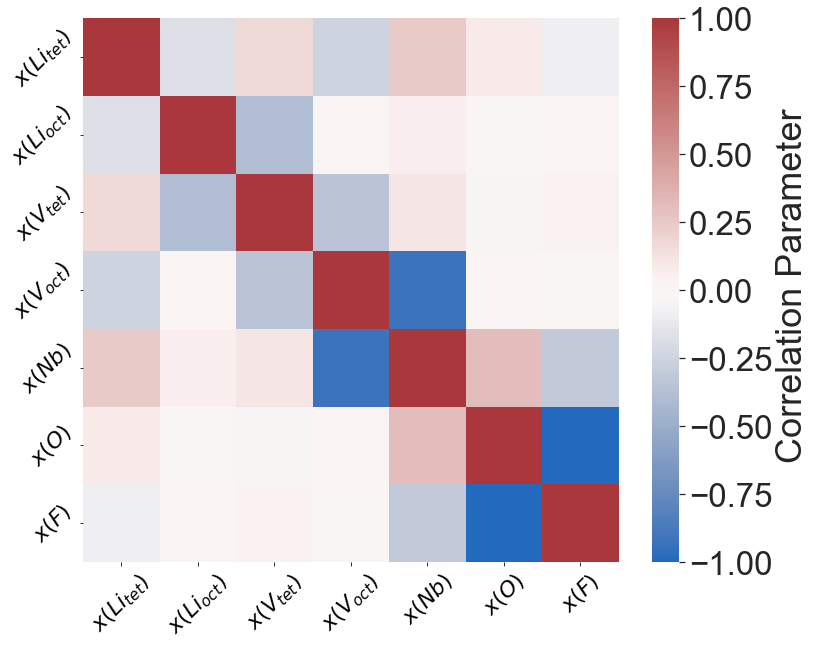

In [8]:
x_li_tet = df_all["x-tet-Li"].values 
x_li_oct = df_all["x-oct-Li"].values
x_v_tet = df_all["x-tet-V"].values
x_v_oct = df_all["x-oct-V"].values
x_nb = df_all["x-Nb"].values
x_o = (2 - df_all["F Frac"].values)/2 # Concentration of O and F are also normalized
x_f = (df_all["F Frac"].values)/2
total_matrix = np.transpose([x_li_tet, x_li_oct, x_v_tet, x_v_oct, x_nb, x_o, x_f]);

site_list = [0, 1, 2, 3, 4, 5, 6] # corresponding to "x_tetli", "x_octli", "x_tetv", "x_octv", "x_nb", "x_o", "x_f" in order
site_name = ["x_li_tet", "x_li_oct", "x_v_tet", "x_v_oct", "x_nb", "x_o", "x_f"]
combination_list = []; pearson_sum = []
index = 0
for i in itertools.combinations(site_list, 4): # Test out all combinations of site variables
    comb = list(i)
    feature = [site_name[comb[0]], site_name[comb[1]], site_name[comb[2]], site_name[comb[3]]]
    feature_matrix = np.transpose([total_matrix[:,comb[0]], total_matrix[:,comb[1]], total_matrix[:,comb[2]], total_matrix[:,comb[3]]]);
    pearson_corr = np.corrcoef(feature_matrix, rowvar=False);
    summation_corr = np.sum(np.absolute(pearson_corr))
    combination_list.append(feature); pearson_sum.append(summation_corr);
    
fitting_parameters = pd.DataFrame(zip(combination_list, pearson_sum), columns = ["Feature Selection", "Pearson Sum"]); 
print(fitting_parameters.sort_values(by=['Pearson Sum']))

corr_matrix = np.transpose([x_li_tet, x_li_oct, x_v_tet, x_v_oct, x_nb, x_o, x_f]);
x_axis_labels = ['$x(Li_{tet})$', '$x(Li_{oct})$', '$x({V_{tet}})$', '$x({V_{oct}})$', '$x(Nb)$', '$x(O)$', '$x(F)$'] # labels for x-axis
y_axis_labels = ['$x(Li_{tet})$', '$x({Li_{oct}})$', '$x({V_{tet}})$', '$x({V_{oct}})$', '$x(Nb)$', '$x(O)$', '$x(F)$'] # labels for y-axis
pearson_corr = np.corrcoef(corr_matrix, rowvar=False)
fig, ax1 = plt.subplots(figsize=(12,10))
sns.set(font_scale=3)
sns.heatmap(pearson_corr, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap = "vlag", cbar_kws={'label': ' Correlation Parameter'})
plt.xticks(fontsize=22, rotation = 45); plt.yticks(fontsize=22, rotation = 45);

sns.set_style("ticks")
plt.rcParams['font.family'] = 'Arial';